# Bootcamp Data Science (Sages sp. z o.o.)

## Norbert Tuśnio

### Final project: Statistical effect of environmental pollution on the formation of various types of cancer

In the project the database of cancers created during the years 1999-2015 was used.<br>
Data source: Wojciechowska Urszula, Didkowska Joanna. Illnesses and deaths from malignant tumors in Poland.<br>
National Cancer Registry, Oncology Center - Instytut im. Maria Skłodowska-Curie.<br>
Available at http://onkologia.org.pl/raporty/ (access: August 2018).<br>
The database contains the following diseases in accordance with the ICD-10 classification<br>
(International Statistical Classification of Diseases and Related Health Problems):<br>
<br>
C00-C97 Malignant neoplasms<br>
C00-C75 Malignant neoplasms, stated or presumed to be primary, of specified sites, except of lymphoid, haematopoietic and related tissue<br>
C00-C14 Malignant neoplasms of lip, oral cavity and pharynx<br>
C15-C26 Malignant neoplasms of digestive organs<br>
C30-C39 Malignant neoplasms of respiratory and intrathoracic organs<br>
C40-C41 Malignant neoplasms of bone and articular cartilage<br>
C43-C44 Melanoma and other malignant neoplasms of skin<br>
C45-C49 Malignant neoplasms of mesothelial and soft tissue<br>
C50-C50 Malignant neoplasm of breast<br>
C51-C58 Malignant neoplasms of female genital organs<br>
C60-C63 Malignant neoplasms of male genital organs<br>
C64-C68 Malignant neoplasms of urinary tract<br>
C69-C72 Malignant neoplasms of eye, brain and other parts of central nervous system<br>
C73-C75 Malignant neoplasms of thyroid and other endocrine glands<br>
C76-C80 Malignant neoplasms of ill-defined, secondary and unspecified sites<br>
C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue<br>
C97-C97 Malignant neoplasms of independent (primary) multiple sites<br>
D00-D09 In situ neoplasms<br>
Last series codes have been changed to numbers 100-109.

In [15]:
# Python module import
import base64
import requests
import html2text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The following function loads cancer statistics from the website onkologia.org.pl for a selected province.<br>
Load method: POST<br>
Available years:  1999-2015<br>
Number of voivodships:   16<br>
Number of sexes:          2<br>
Total possible calls:   544<br>
Principle of operation:<br>
1. Calling the POST method with the parameters "filter" (Base64* coded) and "report"
2. Getting the result in the form of html table
3. Transforming the html table into a text form
4. Separation of individual table lines to the numerical form
5. Summary of the men and women's cases in a given year
6. Expanding the table with information from individual years
7. Returning a Pandas DataFrame with a dimension of 110 rows × 17 columns (rows: disease number, columns: year)<br>
*Base64 is a group of similar binary-to-text encoding schemes that represent binary data in an ASCII string format by translating it into a radix-64 representation. The term Base64 originates from a specific MIME content transfer encoding.

In [6]:
def wczytaj_statystyke_nowotworow(woj):
    url='http://onkologia.org.pl/raporty_online/tabela_nowotwor_wg_wieku.php'
    df=pd.DataFrame()
    for rok in range(1999,2016):
        for mk in range(2):
            if mk==0:
                plec='M'
            else:
                plec='K'
            tekst=str(woj*2)
            if len(tekst)==1:
                tekst='0'+tekst
            tekst='wojewodztwo='+tekst+'&rok%5B%5D='+str(rok)+'&plec='+plec+'&rodzaj=zachorowania'
            filtr=base64.encodebytes(bytes(tekst,'utf-8'))
            payload = {'filtr': filtr,
                      'raport': 'tabela_nowotwor_wg_wieku'
                      }
            r=requests.post(url,data=payload)
            r=html2text.html2text(r.text)
            r=r.splitlines()
            r=r[6:-1]
            x=[]
            for i in r:
                if i[0]=='C' or i[0]=='D':
                    x.append(i)
                else:
                    x[-1]+=i
            r=x
            s=[0]*110
            for i in r:
                x=i.split('|')
                nr=int(x[0][1:])
                if x[0][0]=='D':
                    nr+=100
                for j in range(1,len(x)):
                    s[nr]+=int(x[j])
            if mk==0:
                dfm=pd.Series(s)
            else:
                dfk=pd.Series(s)
        ss=pd.DataFrame(dfm+dfk,columns=[rok])
        df=pd.concat([df,ss],axis=1)
    return df

The second function reads the gas concentration data from the page powietrze.gios.gov.pl/pjp/archives<br>
Load method:     read_excel<br>
Available years:  2000-2016<br>
Number of voivodships:   17<br>
Number of gases:         13<br>
Measuring stations:     264<br>
Principle of operation:<br>
1. The process of transforming the voivodeship number into the full name
2. Loading statistical data from the excel file (3 columns: year, province, average measurement)
3. Cutting data only for one province
4. Data grouping due to the year and calculation of the average of all measurements
5. Selecting data for comparison (correlation)
 - xx - a list containing years in which data on both cancer and air pollution statistics are available
 - y1 - a list containing statistical data on the formation of tumors in subsequent years
 - y2 - a list containing statistical data on air pollution for a given gas
6. Calculation of Pearson's correlation and its best result
7. Determining what type of cancer is most correlated with a given type of air pollution
8. Drawing a line graph<br>
*Pearson correlation coefficient (PCC), also referred to as Pearson's r, the Pearson product-moment correlation coefficient (PPMCC) or the bivariate correlation, is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

In [11]:
def wczytaj_zanieczyszczenia(woj,gaz):
    
    if woj==1: woj='dolnośląskie'
    if woj==2: woj='kujawsko-pomorskie'
    if woj==3: woj='lubelskie'
    if woj==4: woj='lubuskie'
    if woj==5: woj='łódzkie'
    if woj==6: woj='małopolskie'
    if woj==7: woj='mazowieckie'
    if woj==8: woj='opolskie'
    if woj==9: woj='podkarpackie'
    if woj==10: woj='podlaskie'
    if woj==11: woj='pomorskie'
    if woj==12: woj='śląskie'
    if woj==13: woj='świętokrzyskie'
    if woj==14: woj='warmińsko-mazurskie'
    if woj==15: woj='wielkopolskie'
    if woj==16: woj='zachodniopomorskie'

    r=pd.read_excel('Statystyki_2000-2016_wer20170831.xlsx',sheet_name=gaz,usecols='A,B,I')
    r=r[r.Województwo==woj]
    r=r.groupby('Rok').mean()
    rok_od=r.index.min()
    lata=list(r.index)
    lata=lata[:-1]
    ile=len(lata)
    maxx=0
    for rak in range(110):
        xx=[0]*ile
        y1=[0]*ile
        y2=[0]*ile
        i=0
        for rok in lata:
            xx[i]=rok
            y1[i]=df.iat[rak,rok-1999]
            y2[i]=r.iat[i,0]
            i+=1
        korelacja=np.corrcoef(y1,y2)[0,1]
        #print(rak,korelacja,xx)
        if korelacja>maxx:
            maxx=korelacja
            ktory=rak
            xxbest=xx
            y1best=y1
            y2best=y2
        
    plt.plot(xxbest,y1best)
    plt.plot(xxbest,y2best)
    plt.legend(('rak','gaz'))
    plt.show()
    print(woj,gaz,ktory,maxx)

C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


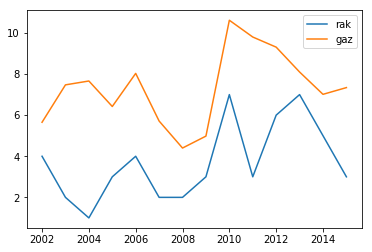

świętokrzyskie SO2 6 0.5460503337708881


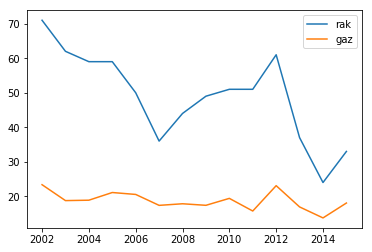

świętokrzyskie NO2 23 0.7880505111186742


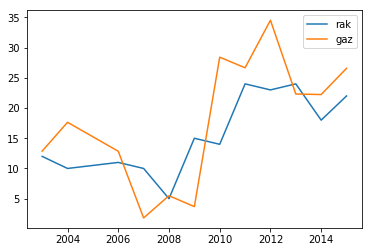

świętokrzyskie NOx 10 0.7392988361055012


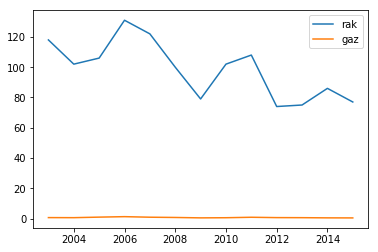

świętokrzyskie CO 53 0.7724314622656535


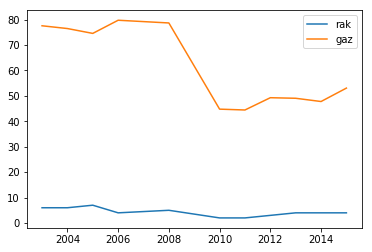

świętokrzyskie O3 31 0.7895180157472365


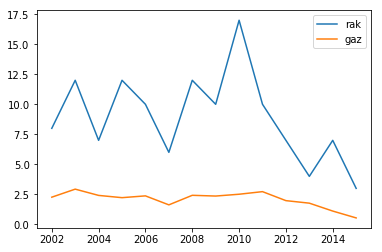

świętokrzyskie C6H6 26 0.716413783694103


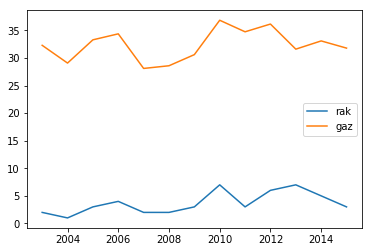

świętokrzyskie PM10 6 0.6756135711407151


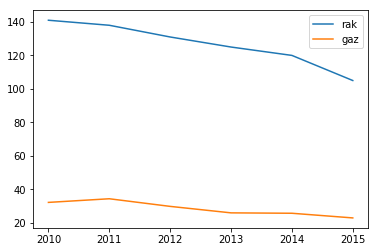

świętokrzyskie PM2,5 25 0.9343175431378351


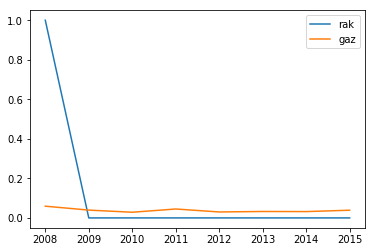

świętokrzyskie Pb(PM10) 58 0.8367073946305489


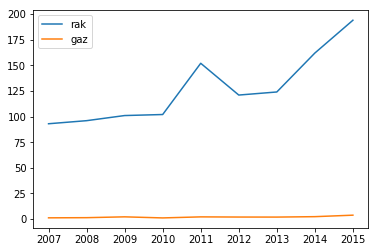

świętokrzyskie As(PM10) 73 0.8877457581445839


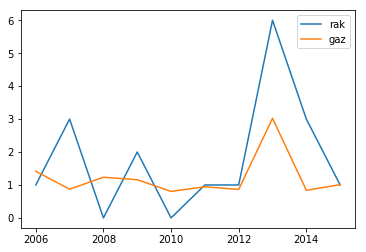

świętokrzyskie Cd(PM10) 52 0.7300901819423935


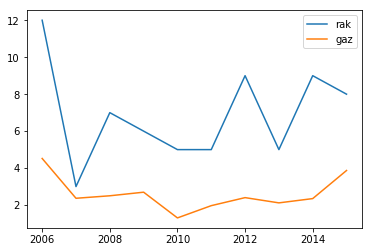

świętokrzyskie Ni(PM10) 60 0.706796922794634


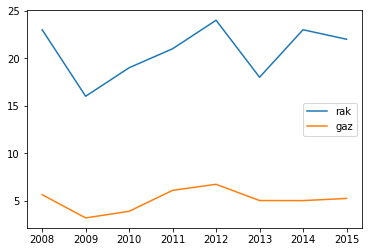

świętokrzyskie BaP(PM10) 49 0.8078896762227536


In [12]:
# Results for one province and all gases
woj=13
gazy=['SO2','NO2','NOx','CO','O3','C6H6','PM10','PM2,5','Pb(PM10)','As(PM10)','Cd(PM10)','Ni(PM10)','BaP(PM10)']
df=wczytaj_statystyke_nowotworow(woj)
for gaz in gazy:
    wczytaj_zanieczyszczenia(woj,gaz)

C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


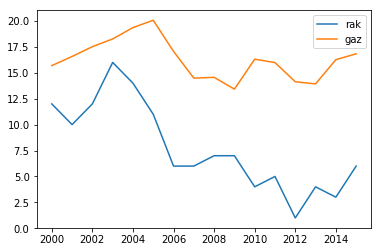

dolnośląskie NO2 96 0.648708094508951


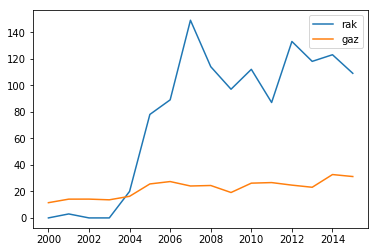

dolnośląskie NOx 83 0.836126369940522


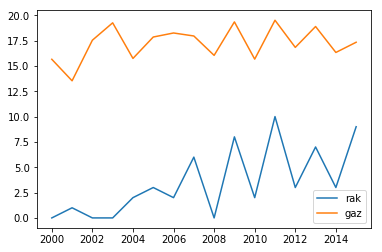

kujawsko-pomorskie NO2 107 0.5475732879804592


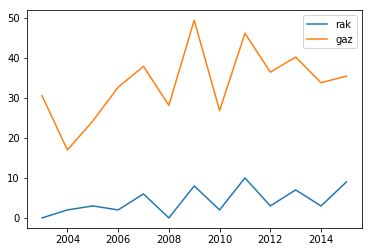

kujawsko-pomorskie NOx 107 0.7433752299584048


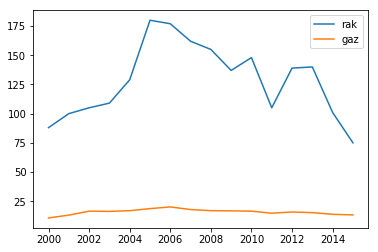

lubelskie NO2 91 0.8547248807276281


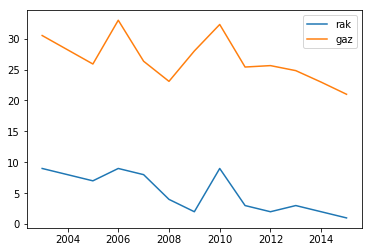

lubelskie NOx 95 0.7838883582157896


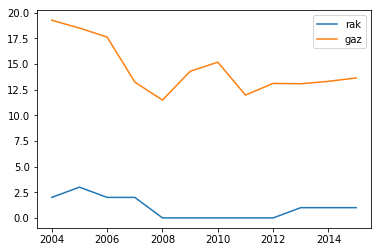

lubuskie NO2 57 0.7171677409953292


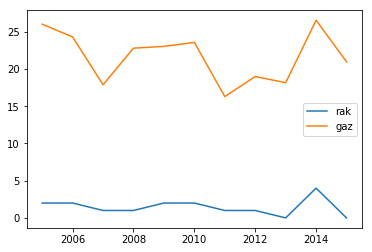

lubuskie NOx 107 0.7431415975951877


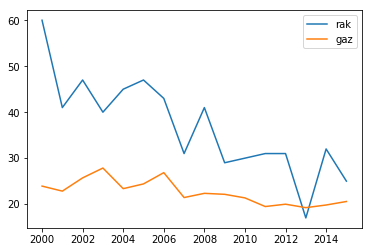

łódzkie NO2 0 0.689096258814644


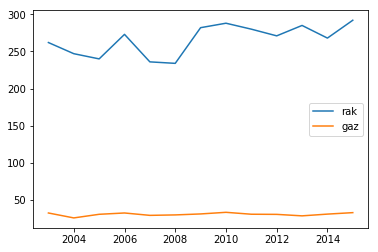

łódzkie NOx 56 0.5077277164265643


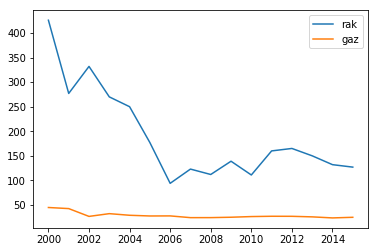

małopolskie NO2 80 0.7841461219280909


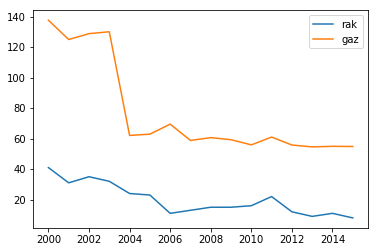

małopolskie NOx 38 0.8955242846617656


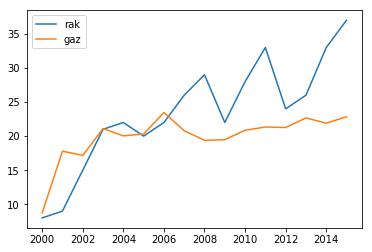

mazowieckie NO2 17 0.724939163090196


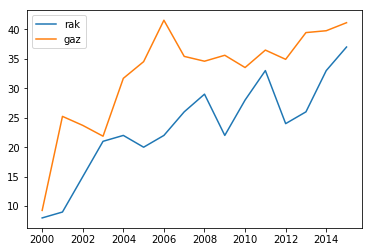

mazowieckie NOx 17 0.7841647299861122


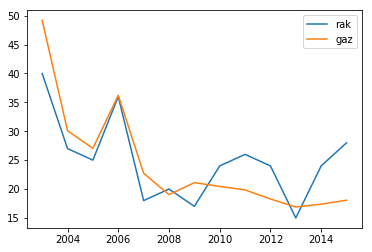

opolskie NO2 80 0.811964775819869


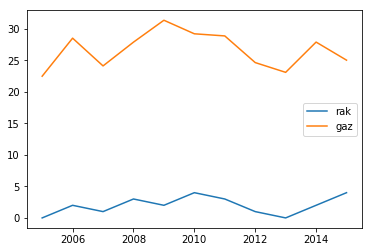

opolskie NOx 26 0.6202274517064109


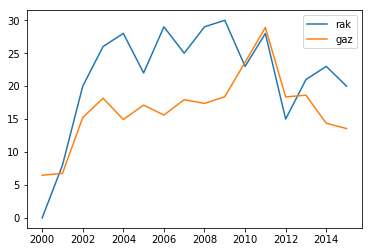

podkarpackie NO2 106 0.6777691855520835


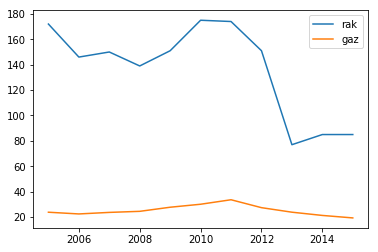

podkarpackie NOx 80 0.6948522972019768


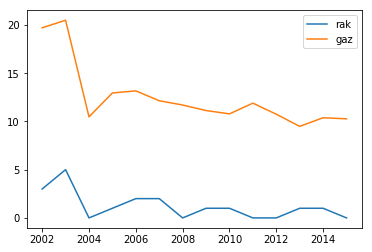

podlaskie NO2 33 0.8648746396918621


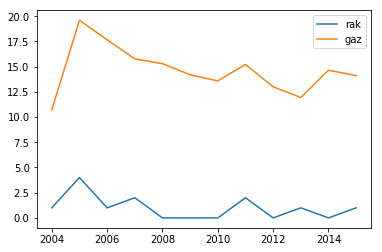

podlaskie NOx 88 0.6018479727497296


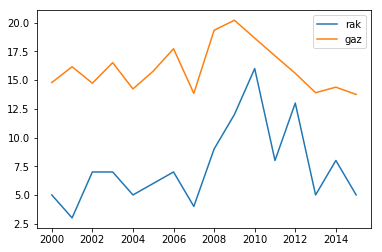

pomorskie NO2 31 0.6341207203006508


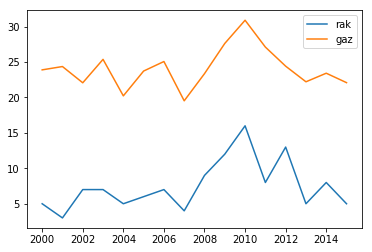

pomorskie NOx 31 0.7428078067231806


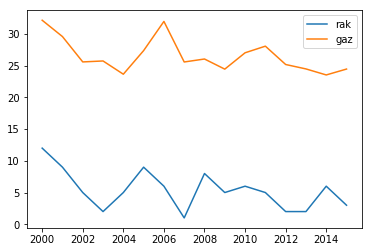

śląskie NO2 33 0.6284456867190849


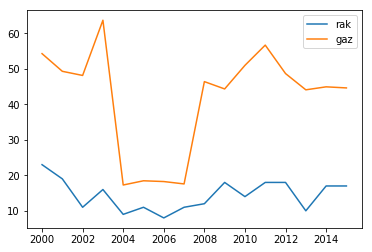

śląskie NOx 57 0.6930375985934447


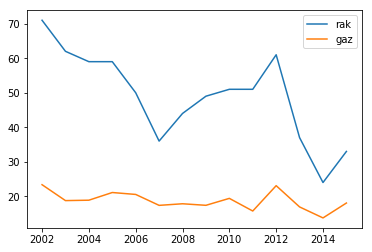

świętokrzyskie NO2 23 0.7880505111186742


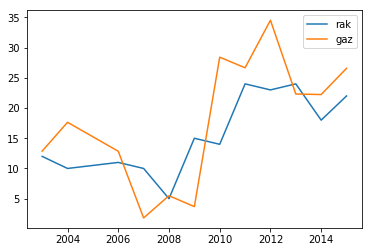

świętokrzyskie NOx 10 0.7392988361055012


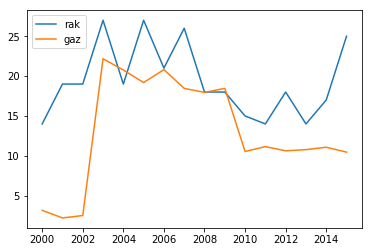

warmińsko-mazurskie NO2 49 0.5112274446354399


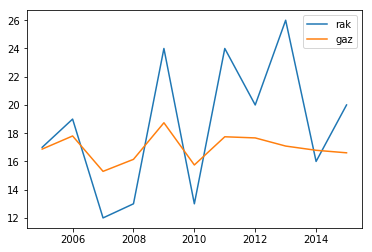

warmińsko-mazurskie NOx 24 0.7963073918245944


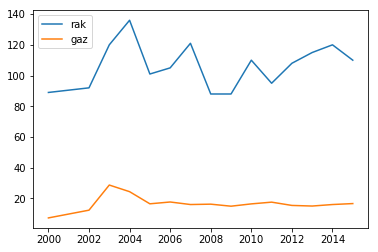

wielkopolskie NO2 92 0.6321257810799722


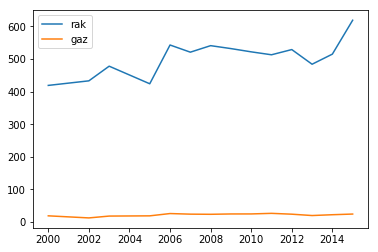

wielkopolskie NOx 67 0.7573695015330046


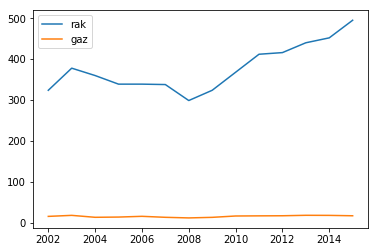

zachodniopomorskie NO2 18 0.7737640542442478


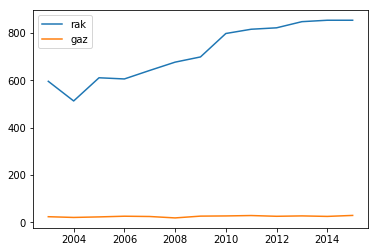

zachodniopomorskie NOx 50 0.6732722774764118


In [13]:
# Results for two gases and all voivodships
gazy=['NO2','NOx']
for woj in range(1,17):
    df=wczytaj_statystyke_nowotworow(woj)
    for gaz in gazy:
        wczytaj_zanieczyszczenia(woj,gaz)

**Conclusions**<br>
1. Nitrogen oxides have been shown to be the best correlated type of gas with cancer statistics.
2. Nitrogen oxides are among the most dangerous compounds polluting the atmosphere. They are several times more harmful than sulfur dioxide and almost ten times more than carbon monoxide. We have enough in Poland. Especially in big cities, because one of the main sources of their emission is road transport.
3. The group of nitrogen oxides consists essentially of six chemical compounds composed of oxygen and nitrogen atoms. From the point of view of the formation of smog, only two are important: nitric oxide (NO) and nitrogen dioxide (NO2). The remaining ones do not occur in the free state or do not have toxic properties.
4. The effects of prolonged exposure to excessive NO2 concentrations are more bleak. Although it is difficult to isolate the effects of the health effects of only nitrogen dioxide alone, because it occurs in smog with other toxic substances, there are scientific grounds to attribute to it the impact on the development of serious illnesses, such as:
 - bronchial asthma,
 - chronic obstructive pulmonary disease,
 - cardiovascular disease
 - and tumors, in particular the lungs and breasts.
5. In Poland alone, the number of deaths attributed to long-term exposure to NO2 is estimated at 1.6 thousand annually. It is worth mentioning that nitrogen oxides also harm us indirectly. They are precursors of carcinogenic compounds formed in soils that can penetrate into food. In this case, their impact on the incidence of chronic diseases and, as a consequence, mortality is very difficult to estimate.
6. Below there are exact results of correlation in given voivodships with the type of cancer:
 - dolnośląskie<br>
&loz; NO2 C96 0.6487080945089510<br>
&loz; NOx C83 0.8361263699405220<br>
 - kujawsko-pomorskie<br>
&loz; NO2 D07 0.5475732879804592<br>
&loz; NOx D07 0.7433752299584048<br>
 - lubelskie<br>
&loz; NO2 C91 0.8547248807276281<br>
&loz; NOx C95 0.7838883582157896<br>
 - lubuskie<br>
&loz; NO2 C57 0.7171677409953292<br>
&loz; NOx D07 0.7431415975951877<br>
 - łódzkie<br>
&loz; NO2 C00 0.6890962588146440<br>
&loz; NOx C56 0.5077277164265643<br>
 - małopolskie<br>
&loz; NO2 C80 0.7841461219280909<br>
&loz; NOx C38 0.8955242846617656<br>
 - mazowieckie<br>
&loz; NO2 C17 0.7249391630901960<br>
&loz; NOx C17 0.7841647299861122<br>
 - opolskie<br>
&loz; NO2 C80 0.8119647758198690<br>
&loz; NOx C26 0.6202274517064109<br>
 - podkarpackie<br>
&loz; NO2 D06 0.6777691855520835<br>
&loz; NOx C80 0.6948522972019768<br>
 - podlaskie<br>
&loz; NO2 C33 0.8648746396918621<br>
&loz; NOx C88 0.6018479727497296<br>
 - pomorskie<br>
&loz; NO2 C31 0.6341207203006508<br>
&loz; NOx C31 0.7428078067231806<br>
 - śląskie<br>
&loz; NO2 C33 0.6284456867190849<br>
&loz; NOx C57 0.6930375985934447<br>
 - świętokrzyskie<br>
&loz; NO2 C23 0.7880505111186742<br>
&loz; NOx C10 0.7392988361055012<br>
 - warmińsko-mazurskie<br>
&loz; NO2 C49 0.5112274446354399<br>
&loz; NOx C24 0.7963073918245944<br>
 - wielkopolskie<br>
&loz; NO2 C92 0.6321257810799722<br>
&loz; NOx C67 0.7573695015330046<br>
 - zachodniopomorskie<br>
&loz; NO2 C18 0.7737640542442478<br>
&loz; NOx C50 0.6732722774764118<br>
7. Based on the above analysis, it was found that the formation of C17 disease (Malignant tumor of the small intestine) is the most correlated with the formation of nitrogen oxides in the Masovia Province. The formation of C18 disease (Malignant colon cancer) is the most correlated with the formation of nitrogen dioxide in the West Pomeranian Voivodeship.
8. Due to the non-uniform location of measurement stations (http://powietrze.gios.gov.pl/pjp/maps/measuringstation), more accurate measurements of hazardous substances should be carried out using a swarm of drones.

**Literature**<br>
1. Wojciechowska U., Didkowska J., Illnesses and deaths from malignant tumors in Poland. National Cancer Registry, Oncology Center - Instytut im. Maria Skłodowska-Curie. Available at http://onkologia.org.pl/raporty/ (access: August 2018)
2. Statistics data from Chief Inspectorate for Environmental Protection. Measurement data bank. Available at http://powietrze.gios.gov.pl/pjp/archives/downloadFile/244 (access: August 2018)
3. https://en.wikipedia.org/wiki/Base64
4. https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
5. https://smoglab.pl/co-i-jak-nas-truje-tlenki-azotu-1/
6. Gagolewski M., Bartoszuk M., Cena A., Data Processing and Analysis in Python. PWN, Warsaw 2016 